In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, MolFromSmiles, MolToSmiles
import requests
import selfies as sf
import time
import numpy as np

from fastcore.xtras import save_pickle

plt.style.use(["science", "nature"])


In [13]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/Ryan-Rhys/The-Photoswitch-Dataset/master/dataset/photoswitches.csv"
)


In [14]:
df.head()


,Unnamed: 0,SMILES,rate of thermal isomerisation from Z-E in s-1,Solvent used for thermal isomerisation rates,Z PhotoStationaryState,E PhotoStationaryState,E isomer pi-pi* wavelength in nm,Extinction,E isomer n-pi* wavelength in nm,Extinction coefficient in M-1 cm-1,...,TPSSh/6-31G** DFT Z isomer pi-pi* wavelength in nm,TPSSh/6-31G** DFT Z isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT E isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT E isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer n-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer n-pi* wavelength in nm,BHLYP/6-31G* Z isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm
0,0,C[N]1N=NC(=N1)N=NC2=CC=CC=C2,2.100000e-07,MeCN,76.0,72.0,310.0,1.67,442.0,0.0373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2,3.800000e-07,MeCN,90.0,84.0,310.0,1.87,438.0,0.0505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,1.100000e-07,MeCN,98.0,97.0,320.0,1.46,425.0,0.0778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2,1.500000e-06,MeCN,96.0,87.0,325.0,1.74,428.0,0.0612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,C[N]1C=C(C=N1)N=NC2=CC=CC=C2,7.600000e-09,MeCN,98.0,70.0,328.0,1.66,417.0,0.0640,...,295.0,410.0,305.0,427.0,256.0,401.0,NaN,NaN,NaN,NaN


/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='E isomer pi-pi* wavelength in nm', ylabel='Density'>

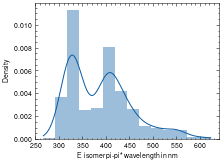

In [15]:
sns.distplot(df["E isomer pi-pi* wavelength in nm"], kde_kws={"cut": 0})


Interesting distribution, spread is wider than I expected scrolling through the csv.


In [16]:
print(
    df["E isomer pi-pi* wavelength in nm"].min(),
    df["E isomer pi-pi* wavelength in nm"].max(),
)


267.0 623.0


In [10]:
df["E isomer pi-pi* wavelength in nm"].isna().sum()


13

The minimum wavelength molecule


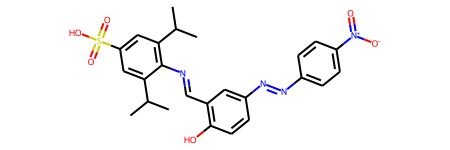

In [20]:
Chem.MolFromSmiles(df.iloc[df["E isomer pi-pi* wavelength in nm"].argmin()]["SMILES"])


Maximum wavelength molecule


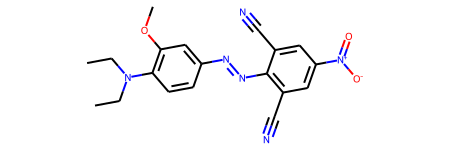

In [23]:
Chem.MolFromSmiles(df.iloc[df["E isomer pi-pi* wavelength in nm"].argmax()]["SMILES"])


Let's also get the SELFIES and then bin the wavelengths for a classification task.


Let's also get chemical names


In [50]:
CACTUS = "https://cactus.nci.nih.gov/chemical/structure/{0}/{1}"


def smiles_to_iupac(smiles):
    try:
        time.sleep(0.1)
        rep = "iupac_name"
        url = CACTUS.format(smiles, rep)
        response = requests.get(url)
        response.raise_for_status()
        name = response.text
        if "html" in name:
            return None
        return name
    except Exception:
        return None


In [31]:
smiles_to_iupac("CCCCC")


'Pentane'

In [33]:
smiles_to_iupac(df.iloc[100]["SMILES"])


'(3,5-dimethyl-1,2-oxazol-4-yl)-(2-methoxyphenyl)diazene'

In [38]:
sf.encoder(df.iloc[100]["SMILES"])


'[C][C][=N][O][C][Branch1][C][C][=C][Ring1][=Branch1][/N][=N][/C][=C][Branch1][Ring1][O][C][C][=C][C][=C][Ring1][Branch2]'

In [39]:
selfies = [sf.encoder(smiles) for smiles in df["SMILES"]]


In [51]:
chemical_names = [smiles_to_iupac(smiles) for smiles in df["SMILES"]]


In [53]:
len(df["SMILES"])


405

In [54]:
df["name"] = chemical_names


In [55]:
df["name"].isna().sum()


316

In [56]:
df["selfies"] = selfies


Now also compute the "fragprints" (using the [original code](https://github.com/Ryan-Rhys/The-Photoswitch-Dataset/blob/master/property_prediction/data_utils.py))


In [59]:
df_w_smiles = df.dropna(subset=["SMILES"])


In [61]:
smiles_list = df_w_smiles["SMILES"]


In [62]:
rdkit_mols = [MolFromSmiles(smiles) for smiles in smiles_list]
rdkit_smiles = [MolToSmiles(mol, isomericSmiles=False) for mol in rdkit_mols]
rdkit_mols = [MolFromSmiles(smiles) for smiles in rdkit_smiles]
X = [AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048) for mol in rdkit_mols]
X = np.asarray(X)

fragments = {d[0]: d[1] for d in Descriptors.descList[115:]}
X1 = np.zeros((len(smiles_list), len(fragments)))
for i in range(len(smiles_list)):
    mol = MolFromSmiles(smiles_list[i])
    try:
        features = [fragments[d](mol) for d in fragments]
    except:
        raise Exception("molecule {}".format(i) + " is not canonicalised")
    X1[i, :] = features

X = np.concatenate((X, X1), axis=1)


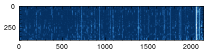

In [77]:
plt.imshow(np.log(X + 1e-8), cmap="RdBu_r")


In [80]:
fragprint_features = dict(zip(smiles_list, X))


In [82]:
save_pickle("../data/fragprint_features.pkl", fragprint_features)


In [85]:
df_w_smiles = df_w_smiles.drop(columns=["Unnamed: 0"])


In [92]:
df_w_smiles["wavelength_cat"] = pd.cut(
    df_w_smiles["E isomer pi-pi* wavelength in nm"],
    5,
    labels=["very small", "small", "medium", "large", "very large"],
)


In [93]:
df_w_smiles.to_csv("../data/photoswitches.csv", index=False)
